# 0. Preparation

In [2]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from tqdm import tqdm
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)
plt.rcParams['figure.figsize'] = [6, 3]

2023-04-06 01:30:42.806834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-06 01:30:42.854735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-06 01:30:42.855548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 01:30:43.586763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


# Load data from Azure blob

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

# Download full data
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Define Constants, Functions

In [5]:
model_dir = "tft_model_15_tft_nogpp_small_lr_230405_0227"
exp_model_dir = f"/root/co2-flux-hourly-gpp-modeling/data/models/{model_dir}"
checkpt_dir = f"{exp_model_dir}/lightning_logs/version_0/checkpoints/"
checkpt = os.listdir(checkpt_dir)[-1]
best_model_path = f"{checkpt_dir}{checkpt}"
print(f"Best model: {checkpt}")

Best model: epoch=16-step=170901.ckpt


In [23]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5
ENCODER_LEN = 24*3   # 7 days
print(f"Training timestemp length = {SUBSET_LEN}.")

# create dataloaders for model
batch_size = 256 
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


In [24]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

## Prepare dataloaders for splits

In [25]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)
train, validation, test = setup_tsdataset_nogpp_slim(train_df, val_df, test_df, ENCODER_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


## Select which split to evaluate

In [26]:
eval_split = 'val'

if eval_split == 'val':
    dataloader = validation
    split_df = val_df.copy()
elif eval_split == 'test':
    dataloader = test
    split_df = test_df.copy()

## Get raw predictions

In [33]:
# Get raw preds (too big to save to disk)
raw_preds = best_tft.predict(dataloader, mode="raw", return_x=False)

# Load actuals and mask, which were saved out in performance_metrics_by_site (should be run first for each model)
try:
    print("Loading actuals and mask from previous eval script")
    with open(exp_model_dir + os.sep + f"{eval_split}_actuals.pkl", "rb") as fin:
        actuals = pickle.load(fin)

    with open(exp_model_dir + os.sep + f"{eval_split}_mask.pkl", "rb") as fin:
        mask = pickle.load(fin)
except:
    print("Unable to lod mask, actuals. Running now...")
    actuals_list = []
    mask_list = []
    for x, y in iter(dataloader):
        actuals_list.append(y[0])
        mask_list.append(x['x_cat'][-1, -1].reshape(-1))
    actuals = torch.cat(actuals_list).reshape(-1)
    mask = torch.logical_not(torch.cat(mask_list))

Loading actuals and mask from previous eval script


In [34]:
# Create a dataframe for the decoded index of dataloader
dec_ind_df = pd.DataFrame(dataloader.decoded_index)
dec_ind_df = pd.merge(dec_ind_df, split_df[['site_id', 'IGBP']].drop_duplicates(), how='left', on='site_id')
dec_ind_df.head(3)

,site_id,time_idx_first,time_idx_last,time_idx_first_prediction,IGBP
0,AU-DaP,350640,350712,350712,GRA
1,AU-DaP,350641,350713,350713,GRA
2,AU-DaP,350642,350714,350714,GRA


## Get overall attention curve and feature importances

In [61]:
# Get avg feature imps
enc_fi_avg = list(torch.mean(torch.mean(raw_preds['encoder_variables'], dim=0).squeeze(), dim=0).numpy())
dec_fi_avg = list(torch.mean(raw_preds['decoder_variables'], dim=0).squeeze().numpy())

{'attention': <Figure size 600x300 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

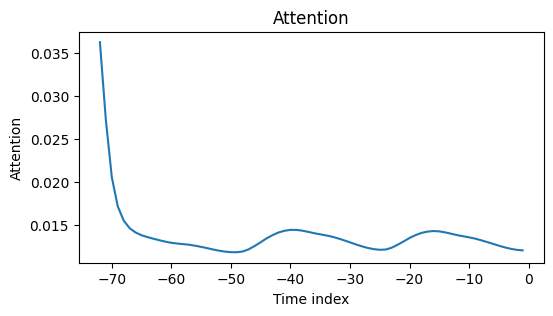

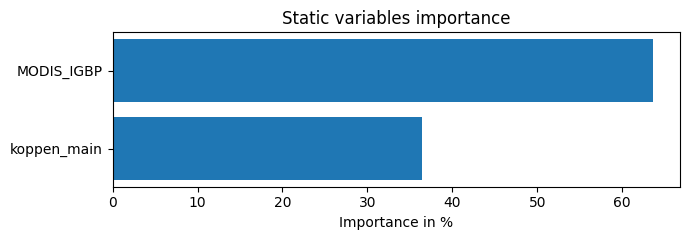

In [ ]:
interpretation_sum = best_tft.interpret_output(raw_preds, reduction="sum")
best_tft.plot_interpretation(interpretation_sum)

## Get feature importances by site

In [57]:
# Align values with features
known_cat=["month", "hour"]
known_real=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'BESS-RSDN']
unknown_cat=["gap_flag_month", "gap_flag_hour"]
enc_features = known_cat + unknown_cat + known_real + ['relative_time_idx'] 
dec_features = known_cat + known_real + ['relative_time_idx'] 

In [59]:
# Create dataframe for site-encoder-feature-imps, site-decoder-feature-imps
site_enc_fi_df = pd.DataFrame(columns= ['site_id'] + enc_features)
site_dec_fi_df = pd.DataFrame(columns= ['site_id'] + dec_features)

# Add average attn to dfs
site_enc_fi_df.loc[len(site_enc_fi_df)] = ['Average'] + enc_fi_avg
site_dec_fi_df.loc[len(site_dec_fi_df)] = ['Average'] + dec_fi_avg

# Loop through sites, getting enc and dec feature importances
for site in tqdm(dec_ind_df['site_id'].unique()):
    # Get site feature imps
    site_inds = dec_ind_df.loc[dec_ind_df['site_id']==site, ].index
    site_enc_fi_means = list(torch.mean(torch.mean(raw_preds['encoder_variables'][site_inds], dim=0).squeeze(), dim=0).numpy())
    site_dec_fi_means = list(torch.mean(raw_preds['decoder_variables'][site_inds], dim=0).squeeze().numpy())

    # Append to df
    site_enc_fi_df.loc[len(site_enc_fi_df)] = [site] + site_enc_fi_means
    site_dec_fi_df.loc[len(site_dec_fi_df)] = [site] + site_dec_fi_means

    
# Save site-fi dfs
site_enc_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_site_encoder_feature_imps.csv'), index=False)
site_dec_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_site_decoder_feature_imps.csv'), index=False)

100%|██████████| 26/26 [00:03<00:00,  8.03it/s]


## Get feature importances by IGBP

In [62]:
# Create dataframe for site-encoder-feature-imps, site-decoder-feature-imps
igbp_enc_fi_df = pd.DataFrame(columns= ['IGBP'] + enc_features)
igbp_dec_fi_df = pd.DataFrame(columns= ['IGBP'] + dec_features)

# Add average attn to dfs
igbp_enc_fi_df.loc[len(igbp_enc_fi_df)] = ['Average'] + enc_fi_avg
igbp_dec_fi_df.loc[len(igbp_dec_fi_df)] = ['Average'] + dec_fi_avg

# Loop through IGBPS, getting enc and dec feature importances
for igbp in tqdm(dec_ind_df['IGBP'].unique()):
    # Get site feature imps
    igbp_inds = dec_ind_df.loc[dec_ind_df['IGBP']==igbp, ].index
    igbp_enc_fi_means = list(torch.mean(torch.mean(raw_preds['encoder_variables'][igbp_inds], dim=0).squeeze(), dim=0).numpy())
    igbp_dec_fi_means = list(torch.mean(raw_preds['decoder_variables'][igbp_inds], dim=0).squeeze().numpy())

    # Append to df
    igbp_enc_fi_df.loc[len(igbp_enc_fi_df)] = [site] + igbp_enc_fi_means
    igbp_dec_fi_df.loc[len(igbp_dec_fi_df)] = [site] + igbp_dec_fi_means
    
    
# Save site-fi dfs
igbp_enc_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_igbp_encoder_feature_imps.csv'), index=False)
igbp_dec_fi_df.to_csv(os.path.join(exp_model_dir, f'{eval_split}_igbp_decoder_feature_imps.csv'), index=False)

100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


## Investigate tables

In [68]:
print("Display encoder feature importance df by site")
styled_enc_df = site_enc_fi_df.style.background_gradient(cmap='Greens')
display(styled_enc_df)

print("\nDisplay decoder feature importance df by site")
styled_dec_df = site_dec_fi_df.style.background_gradient(cmap='Greens')
display(styled_dec_df)

Display encoder feature importance df by site


,site_id,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.023694,0.029087,0.107255,0.288087,0.055782,0.061842,0.039058,0.027755,0.049293,0.037421,0.070319,0.096694,0.038699,0.038026,0.036989
1,AU-DaP,0.015841,0.022332,0.043747,0.230981,0.070929,0.043184,0.046548,0.039243,0.013906,0.034010,0.058545,0.153899,0.063086,0.054592,0.109157
2,AU-Emr,0.032690,0.028802,0.065079,0.228248,0.065750,0.027311,0.066210,0.021723,0.017602,0.067880,0.152088,0.099665,0.051652,0.047990,0.027310
3,AU-Gin,0.017944,0.032209,0.063164,0.300933,0.045596,0.041655,0.060414,0.028985,0.008628,0.035977,0.062596,0.112817,0.059680,0.060054,0.069348
4,AU-How,0.017747,0.021693,0.037644,0.327067,0.052560,0.039038,0.047406,0.038370,0.012159,0.032551,0.030514,0.140696,0.053578,0.051158,0.097818
5,AU-Rig,0.015964,0.026697,0.074667,0.280276,0.052529,0.064362,0.042027,0.036063,0.010157,0.030193,0.071444,0.120048,0.053429,0.046649,0.075495
6,CA-Ca1,0.024252,0.032030,0.136139,0.310642,0.099484,0.108666,0.020577,0.032397,0.015457,0.036452,0.009429,0.082104,0.032094,0.034015,0.026262
7,CA-Gro,0.024936,0.029818,0.163528,0.329192,0.087881,0.052333,0.027781,0.019182,0.022329,0.053994,0.031416,0.087310,0.027929,0.027742,0.014629
8,CH-Fru,0.024634,0.027318,0.116412,0.286162,0.064516,0.081013,0.025064,0.024182,0.022969,0.046891,0.089072,0.117382,0.026115,0.033899,0.014373
9,CH-Oe2,0.022624,0.028782,0.114747,0.391348,0.048155,0.112072,0.021999,0.025259,0.013145,0.031031,0.035959,0.068132,0.036006,0.032688,0.018053



Display decoder feature importance df by site


,site_id,month,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.037195,0.025360,0.067320,0.206960,0.088916,0.059215,0.032021,0.055660,0.084046,0.111674,0.121505,0.100979,0.009149
1,AU-DaP,0.040749,0.029889,0.084538,0.210244,0.070922,0.063346,0.023255,0.082314,0.089811,0.108508,0.118730,0.068342,0.009352
2,AU-Emr,0.040394,0.026039,0.080732,0.289074,0.064434,0.060731,0.024936,0.046867,0.073546,0.172673,0.069373,0.042485,0.008717
3,AU-Gin,0.042767,0.021707,0.063478,0.156174,0.072131,0.059808,0.015228,0.042078,0.075368,0.134119,0.179184,0.129617,0.008342
4,AU-How,0.042779,0.021735,0.073297,0.197362,0.073882,0.064869,0.023641,0.063227,0.095076,0.116683,0.124303,0.095598,0.007546
5,AU-Rig,0.040078,0.025369,0.072654,0.231248,0.087417,0.061369,0.020794,0.067406,0.079062,0.108082,0.116775,0.080944,0.008804
6,CA-Ca1,0.039515,0.025050,0.068407,0.310028,0.138539,0.059051,0.026346,0.057664,0.100311,0.081982,0.030679,0.051071,0.011357
7,CA-Gro,0.034893,0.025524,0.064343,0.252457,0.093070,0.057459,0.024654,0.057520,0.092141,0.101700,0.098234,0.088066,0.009939
8,CH-Fru,0.031424,0.025663,0.067408,0.252695,0.091842,0.055087,0.032206,0.076603,0.091215,0.063625,0.119156,0.082891,0.010185
9,CH-Oe2,0.039912,0.018308,0.059297,0.210983,0.098300,0.061757,0.029228,0.054624,0.084079,0.101015,0.120300,0.114505,0.007691


In [69]:
print("Display encoder feature importance df by site")
styled_igbp_enc_df = igbp_enc_fi_df.style.background_gradient(cmap='Greens')
display(styled_igbp_enc_df)

print("\nDisplay decoder feature importance df by site")
styled_igbp_dec_df = igbp_dec_fi_df.style.background_gradient(cmap='Greens')
display(styled_igbp_dec_df)

Display encoder feature importance df by site


,IGBP,month,hour,gap_flag_month,gap_flag_hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.023694,0.029087,0.107255,0.288087,0.055782,0.061842,0.039058,0.027755,0.049293,0.037421,0.070319,0.096694,0.038699,0.038026,0.036989
1,US-Twt,0.021227,0.026653,0.080211,0.268788,0.057966,0.056305,0.042479,0.029444,0.017207,0.040403,0.100376,0.116284,0.044963,0.045658,0.052034
2,US-Twt,0.017824,0.025810,0.047634,0.316837,0.049834,0.040062,0.052498,0.034696,0.010777,0.033892,0.043072,0.129783,0.055966,0.054640,0.086673
3,US-Twt,0.024457,0.027499,0.127365,0.256889,0.062052,0.062277,0.036388,0.021992,0.098832,0.042384,0.055020,0.085335,0.039799,0.033265,0.026447
4,US-Twt,0.024936,0.029818,0.163528,0.329192,0.087881,0.052333,0.027781,0.019182,0.022329,0.053994,0.031416,0.087310,0.027929,0.027742,0.014629
5,US-Twt,0.026237,0.039325,0.103106,0.305490,0.043804,0.072269,0.061374,0.024640,0.011624,0.033348,0.062924,0.113179,0.035585,0.043045,0.024050
6,US-Twt,0.020759,0.028679,0.107838,0.421134,0.053758,0.085346,0.021668,0.031849,0.011076,0.027418,0.027448,0.080264,0.027205,0.028746,0.026810
7,US-Twt,0.018470,0.022685,0.039799,0.224503,0.088124,0.092386,0.020313,0.064394,0.014187,0.026801,0.011018,0.182381,0.031580,0.038768,0.124589
8,US-Twt,0.026214,0.031794,0.224951,0.160732,0.038405,0.070243,0.042210,0.028493,0.033480,0.030930,0.111397,0.062386,0.081785,0.042623,0.014358
9,US-Twt,0.033036,0.027297,0.108789,0.206182,0.040168,0.017909,0.037718,0.016695,0.169120,0.046358,0.187638,0.045034,0.021126,0.032937,0.009994



Display decoder feature importance df by site


,IGBP,month,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,BESS-RSDN,relative_time_idx
0,Average,0.037195,0.025360,0.067320,0.206960,0.088916,0.059215,0.032021,0.055660,0.084046,0.111674,0.121505,0.100979,0.009149
1,US-Twt,0.037599,0.026325,0.073103,0.225798,0.079948,0.059394,0.024685,0.065176,0.082249,0.110202,0.125562,0.080851,0.009108
2,US-Twt,0.042775,0.021724,0.069453,0.181239,0.073197,0.062888,0.020348,0.054949,0.087361,0.123508,0.145786,0.108915,0.007858
3,US-Twt,0.036563,0.022149,0.059203,0.205849,0.095603,0.056286,0.048405,0.047156,0.078509,0.115489,0.119791,0.105152,0.009844
4,US-Twt,0.034893,0.025524,0.064343,0.252457,0.093070,0.057459,0.024654,0.057520,0.092141,0.101700,0.098234,0.088066,0.009939
5,US-Twt,0.037640,0.023544,0.065573,0.207183,0.092353,0.061083,0.021907,0.051081,0.086964,0.114593,0.119703,0.109524,0.008853
6,US-Twt,0.036235,0.024940,0.067491,0.212050,0.099017,0.061446,0.022614,0.063182,0.088540,0.086836,0.098263,0.130396,0.008990
7,US-Twt,0.039545,0.049744,0.105656,0.216641,0.113208,0.066455,0.025364,0.122266,0.115537,0.043451,0.051422,0.039598,0.011113
8,US-Twt,0.037416,0.018745,0.050806,0.210920,0.090539,0.062823,0.026107,0.049685,0.072692,0.110085,0.107119,0.153682,0.009379
9,US-Twt,0.034209,0.029393,0.068810,0.160900,0.063754,0.052253,0.053004,0.023891,0.073388,0.171851,0.193202,0.067598,0.007747


## Get attention curve by site

In [ ]:
# TO-DO NEXT

## Get attention curve by IGBP